# Coffee Sales Forecasting

This notebook analyzes daily coffee sales using the **Coffee Sales dataset** from Kaggle:  
🔗 https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales

The objective is to forecast sales and compare **classical time series modeling (SARIMAX)** with **deep learning (LSTM)** using Mean Absolute Error (MAE). The workflow includes data preprocessing, feature engineering, model evaluation, and post-model interpretation.


## 0) Setup

In [1]:
import kagglehub
import os
import joblib
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

## 1) Data Loading


In [2]:
# Download latest version
path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

print("Path to dataset files:", path)

100%|██████████| 8.23M/8.23M [00:00<00:00, 103MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ahmedabbas757/coffee-sales/versions/1


In [3]:
path = "/root/.cache/kagglehub/datasets/ahmedabbas757/coffee-sales/versions/1"

os.listdir(path)

['Coffee Shop Sales.xlsx']

In [4]:
df = pd.read_excel(os.path.join(path, "Coffee Shop Sales.xlsx"))

## 2) Data Overview


In [5]:
df.head(10)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
5,6,2023-01-01,07:22:41,1,5,Lower Manhattan,77,3.00,Bakery,Scone,Oatmeal Scone
6,7,2023-01-01,07:25:49,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
7,8,2023-01-01,07:33:34,2,5,Lower Manhattan,28,2.00,Coffee,Gourmet brewed coffee,Columbian Medium Roast Sm
8,9,2023-01-01,07:39:13,1,5,Lower Manhattan,39,4.25,Coffee,Barista Espresso,Latte Rg
9,10,2023-01-01,07:39:34,2,5,Lower Manhattan,58,3.50,Drinking Chocolate,Hot chocolate,Dark chocolate Rg


In [6]:
df.shape

(149116, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [8]:
# Check for null values
df.isnull().sum()

,0
transaction_id,0
transaction_date,0
transaction_time,0
transaction_qty,0
store_id,0
store_location,0
product_id,0
unit_price,0
product_category,0
product_type,0


In [9]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [10]:
# Check for illogical values
df[['transaction_qty', 'unit_price']].describe()

,transaction_qty,unit_price
count,149116.000000,149116.000000
mean,1.438276,3.382219
std,0.542509,2.658723
min,1.000000,0.800000
25%,1.000000,2.500000
50%,1.000000,3.000000
75%,2.000000,3.750000
max,8.000000,45.000000


In [11]:
# Check date and time format
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S', errors='coerce').dt.time

The dataset was inspected for missing values, incorrect data types, and invalid numerical entries. No data cleaning operations were required, as the dataset was already well-structured and consistent.

## 3) Raw Data EDA

### 3.1) How large and complex is the dataset?

In [12]:
df.nunique()

,0
transaction_id,149116
transaction_date,181
transaction_time,25762
transaction_qty,6
store_id,3
store_location,3
product_id,80
unit_price,41
product_category,9
product_type,29


The dataset consists of 149,116 transactions in 3 branchs and covering 9 product categories, 29 product types, and 80 distinct product details, indicating a diverse and high-volume retail dataset.

### 3.2) What time period does the dataset cover?


In [13]:
# Confirm date range
df['transaction_date'].min(), df['transaction_date'].max()

(Timestamp('2023-01-01 00:00:00'), Timestamp('2023-06-30 00:00:00'))

The dataset covers a six-month period from January 1, 2023 to June 30, 2023.
This continuous time span provides sufficient temporal resolution for daily time-series analysis.

### 3.3) How are products structured across categories and types?

In [14]:
df.groupby('product_category')['product_type'].nunique()

,product_type
product_category,
Bakery,3
Branded,2
Coffee,5
Coffee beans,6
Drinking Chocolate,1
Flavours,2
Loose Tea,4
Packaged Chocolate,2
Tea,4


In [15]:
df.groupby(['product_category', 'product_type'])['product_detail'].nunique()


product_category    product_type         
Bakery              Biscotti                 3
                    Pastry                   3
                    Scone                    5
Branded             Clothing                 1
                    Housewares               2
Coffee              Barista Espresso         6
                    Drip coffee              3
                    Gourmet brewed coffee    6
                    Organic brewed coffee    3
                    Premium brewed coffee    3
Coffee beans        Espresso Beans           2
                    Gourmet Beans            2
                    Green beans              1
                    House blend Beans        1
                    Organic Beans            2
                    Premium Beans            2
Drinking Chocolate  Hot chocolate            4
Flavours            Regular syrup            3
                    Sugar free syrup         1
Loose Tea           Black tea                2
                    Chai tea                 3
                    Green tea                1
                    Herbal tea               2
Packaged Chocolate  Drinking Chocolate       2
                    Organic Chocolate        1
Tea                 Brewed Black tea         4
                    Brewed Chai tea          6
                    Brewed Green tea         2
                    Brewed herbal tea        4
Name: product_detail, dtype: int64

### 3.4) How are transactions distributed across store locations?

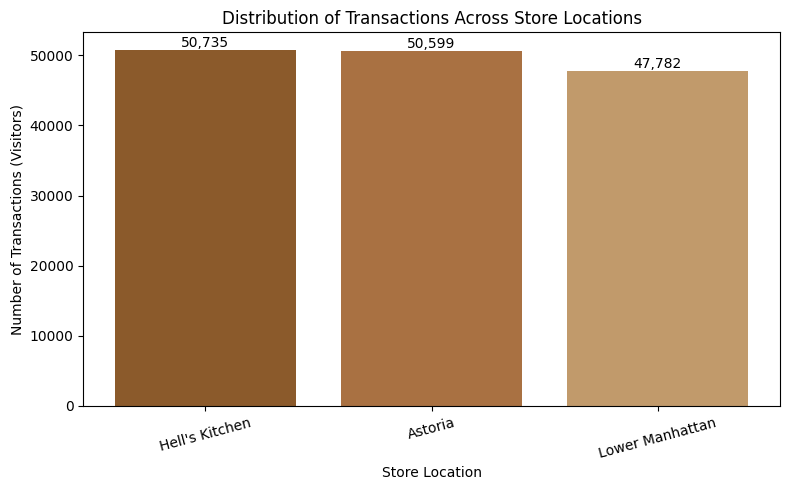

In [16]:
counts = df['store_location'].value_counts()

brown_colors = ['#8B5A2B', '#A97142', '#C19A6B']
plt.figure(figsize=(8, 5))
bars = plt.bar(
    counts.index,
    counts.values,
    color=brown_colors
)

plt.title('Distribution of Transactions Across Store Locations')
plt.xlabel('Store Location')
plt.ylabel('Number of Transactions (Visitors)')
plt.xticks(rotation=15)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

### 3.5) How do transactions evolve over time?

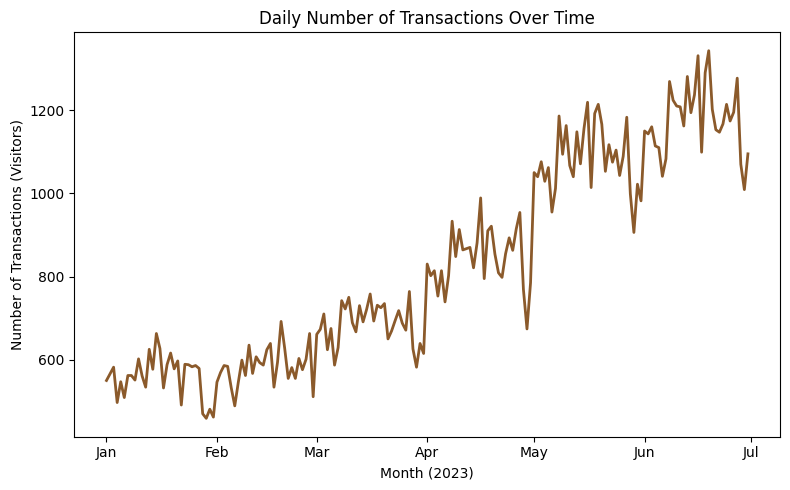

In [17]:
daily_transactions = df['transaction_date'].value_counts().sort_index()

plt.figure(figsize=(8, 5))

plt.plot(
    daily_transactions.index,
    daily_transactions.values,
    color='#8B5A2B',
    linewidth=2
)

# Asis titles
plt.title('Daily Number of Transactions Over Time')
plt.xlabel('Month (2023)')
plt.ylabel('Number of Transactions (Visitors)')

# Time axis format (months)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()


## 4) Feature Engineering

### 4.1) Sales Feature Construction

In [18]:
# Add sale feature
df['sales'] = df['transaction_qty'] * df['unit_price']

# Check on samples if sales equal unit price * quantity of items sold
df[['transaction_qty','unit_price','sales']].head()

,transaction_qty,unit_price,sales
0,2,3.0,6.0
1,2,3.1,6.2
2,2,4.5,9.0
3,1,2.0,2.0
4,2,3.1,6.2


### 4.2) Daily Aggregation

In [19]:
# Overall daily sales (Series)
overall_daily_sales = (
    df.groupby('transaction_date', as_index=False)['sales']
      .sum()
      .set_index('transaction_date')
      .sort_index()
)

In [20]:
# Daily sales per branch (long DataFrame)
daily_sales = (
    df.groupby(['transaction_date', 'store_location'], as_index=False)['sales']
      .sum()
      .sort_values('transaction_date')
)

In [21]:
# Quick look
print(overall_daily_sales.tail())
print('\n', daily_sales.head())

                    sales
transaction_date         
2023-06-26        5875.90
2023-06-27        5975.65
2023-06-28        4728.90
2023-06-29        4450.75
2023-06-30        5481.32

   transaction_date   store_location   sales
0       2023-01-01          Astoria  868.40
1       2023-01-01   Hell's Kitchen  851.45
2       2023-01-01  Lower Manhattan  788.35
3       2023-01-02          Astoria  925.50
4       2023-01-02   Hell's Kitchen  828.80


### 4.3) Calendar-Based Features

In [22]:
daily_index = pd.date_range(
    start=overall_daily_sales.index.min(),
    end=overall_daily_sales.index.max(),
    freq='D'
)

# Overall daily frame (target + calendar)
overall_daily_df = overall_daily_sales.asfreq('D').fillna(0).rename(columns={'sales':'y'})
overall_daily_df = overall_daily_df.reindex(daily_index)
overall_daily_df.index.name = 'transaction_date'

overall_daily_df['day_of_week'] = overall_daily_df.index.dayofweek  # 0=Mon ... 6=Sun
overall_daily_df['is_weekend']  = (overall_daily_df['day_of_week'] >= 5).astype(int)

overall_daily_df.head()

,y,day_of_week,is_weekend
transaction_date,,,
2023-01-01,2508.20,6,1
2023-01-02,2403.35,0,0
2023-01-03,2565.00,1,0
2023-01-04,2220.10,2,0
2023-01-05,2418.85,3,0


### 4.4) External Features (Weather)

In [23]:
# NOTE: This uses NYC coordinates.
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=40.7128&longitude=-74.0060"
    f"&start_date={overall_daily_df.index.min().date()}"
    f"&end_date={overall_daily_df.index.max().date()}"
    "&daily=temperature_2m_mean,precipitation_sum"
    "&timezone=America/New_York"
)

weather_json = requests.get(url, timeout=60).json()

weather_df = pd.DataFrame({
    'transaction_date': weather_json['daily']['time'],
    'avg_temp': weather_json['daily']['temperature_2m_mean'],
    'rain': weather_json['daily']['precipitation_sum']
})
weather_df['transaction_date'] = pd.to_datetime(weather_df['transaction_date'])

# merge into overall_daily_df
overall_daily_df = (
    overall_daily_df.reset_index()
    .merge(weather_df, on='transaction_date', how='left')
    .set_index('transaction_date')
    .sort_index()
)

# engineered weather flags
overall_daily_df['cold_day']  = (overall_daily_df['avg_temp'] <= 5).astype(int)
overall_daily_df['hot_day']   = (overall_daily_df['avg_temp'] >= 25).astype(int)
overall_daily_df['rainy_day'] = (overall_daily_df['rain'] > 0).astype(int)

overall_daily_df[['y','is_weekend','avg_temp','rain','cold_day','rainy_day']].head()

,y,is_weekend,avg_temp,rain,cold_day,rainy_day
transaction_date,,,,,,
2023-01-01,2508.20,1,8.8,1.1,0,1
2023-01-02,2403.35,0,8.0,0.6,0,1
2023-01-03,2565.00,0,9.7,9.4,0,1
2023-01-04,2220.10,0,13.1,2.3,0,1
2023-01-05,2418.85,0,9.9,0.0,0,0


### 4.5 Lag & Rolling features (mainly for LSTM / ML)

In [24]:
# lags
overall_daily_df['lag_1'] = overall_daily_df['y'].shift(1)
overall_daily_df['lag_7'] = overall_daily_df['y'].shift(7)

# rolling (use shift(1) to avoid leakage from today's value)
overall_daily_df['roll_mean_7'] = overall_daily_df['y'].shift(1).rolling(window=7).mean()
overall_daily_df['roll_std_7']  = overall_daily_df['y'].shift(1).rolling(window=7).std()

# final preview + check missing created by lags/rolling
overall_daily_df.tail(10), overall_daily_df.isna().sum()

(                        y  day_of_week  is_weekend  avg_temp  rain  cold_day  \
 transaction_date                                                               
 2023-06-21        5808.38            2           0      18.8   0.3         0   
 2023-06-22        5615.10            3           0      18.2   0.3         0   
 2023-06-23        5781.86            4           0      19.9  15.6         0   
 2023-06-24        5906.10            5           1      21.7  18.0         0   
 2023-06-25        5754.85            6           1      23.0   1.9         0   
 2023-06-26        5875.90            0           0      21.8   4.6         0   
 2023-06-27        5975.65            1           0      21.8  18.7         0   
 2023-06-28        4728.90            2           0      22.8   2.1         0   
 2023-06-29        4450.75            3           0      22.4   0.0         0   
 2023-06-30        5481.32            4           0      23.0   0.0         0   
 
                   hot_day

### 4.6 Branch-level daily frames

In [25]:
# pivot to wide: columns=branch, index=date
branch_daily_wide = (
    daily_sales.pivot_table(
        index='transaction_date',
        columns='store_location',
        values='sales',
        aggfunc='sum'
    )
    .reindex(daily_index)
    .fillna(0)
)

branch_daily_wide.index.name = 'transaction_date'
branch_daily_wide.head()

store_location,Astoria,Hell's Kitchen,Lower Manhattan
transaction_date,,,
2023-01-01,868.40,851.45,788.35
2023-01-02,925.50,828.80,649.05
2023-01-03,902.75,906.25,756.00
2023-01-04,808.25,781.65,630.20
2023-01-05,903.05,714.90,800.90


## 5) Classical Forecasting (SARIMAX)

### 5.1) Preparation + Helper Functions

In [26]:
TEST_DAYS = 14

def time_split(y, X=None, test_days=14):
    y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]
    if X is None:
        return y_train, y_test, None, None
    X_train, X_test = X.loc[y_train.index], X.loc[y_test.index]
    return y_train, y_test, X_train, X_test

def plot_test_only(y_test, y_pred, title, ylabel="Sales"):
    plt.figure(figsize=(9, 3))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
    plt.plot(y_pred.index, y_pred.values, label="Forecast", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def build_exog(df):
    """
    Builds SARIMAX exogenous matrix (X) aligned with df index.
    Requires in df: day_of_week, is_weekend, avg_temp, rain, cold_day, rainy_day
    """
    base = df[['is_weekend', 'cold_day', 'rainy_day', 'avg_temp', 'rain']].copy()
    base = base.fillna(0).astype(float)

    dow = pd.get_dummies(df['day_of_week'], prefix="dow", drop_first=True).astype(float)
    X = pd.concat([base, dow], axis=1)
    return X

def fit_sarimax_forecast(y_train, y_test, X_train=None, X_test=None,
                         order=(1,1,1), seasonal_order=(1,1,1,7)):
    model = SARIMAX(
        y_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    fc = res.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
    fc.index = y_test.index
    mae = mean_absolute_error(y_test, fc)
    return fc, mae, res

### 5.2) SARIMAX (Overall)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Overall MAE (Test-14 days): 437.04


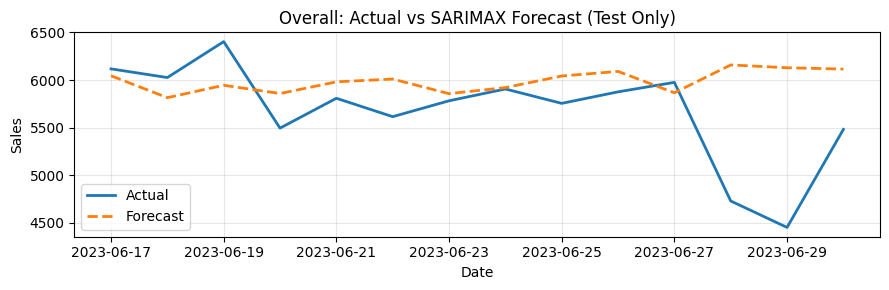

In [27]:
# Overall target
overall_y = overall_daily_df['y'].astype(float).copy()

# Overall exogenous
overall_X = build_exog(overall_daily_df)

# Split
y_train, y_test, X_train, X_test = time_split(overall_y, overall_X, test_days=TEST_DAYS)

# Fit + Forecast
overall_pred, overall_mae, overall_sarimax_res = fit_sarimax_forecast(
    y_train, y_test, X_train, X_test,
    order=(1,1,1), seasonal_order=(1,1,1,7)
)

print(f"SARIMAX Overall MAE (Test-{TEST_DAYS} days): {overall_mae:.2f}")

# Plot (test only)
plot_test_only(y_test, overall_pred, title="Overall: Actual vs SARIMAX Forecast (Test Only)")

### 5.3) SARIMAX (Branch-level)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


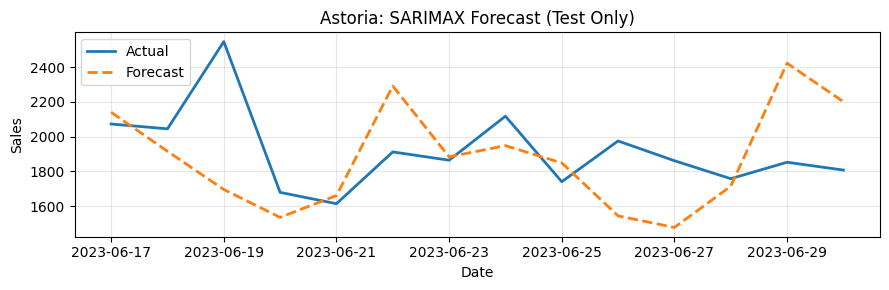

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


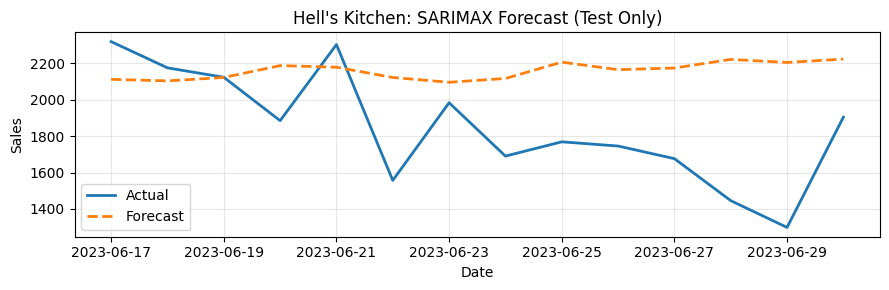

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


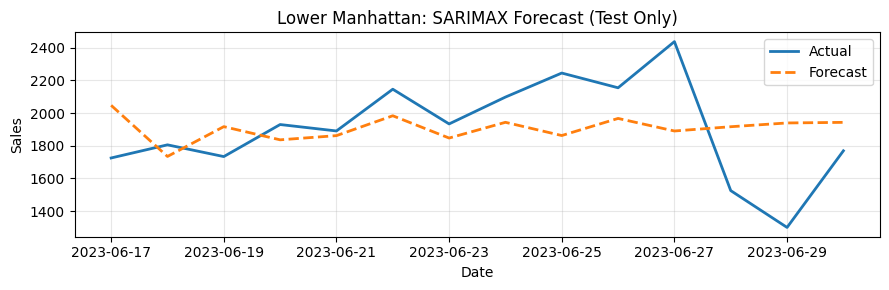

In [28]:
branches = branch_daily_wide.columns.tolist()
sarimax_branch_results = {}

for b in branches:
    y_b = branch_daily_wide[b].astype(float).copy()

    # Align exog to the branch index (same dates)
    X_b = overall_X.loc[y_b.index].copy()

    y_tr, y_te, X_tr, X_te = time_split(y_b, X_b, test_days=TEST_DAYS)

    try:
        pred_b, mae_b, res_b = fit_sarimax_forecast(
            y_tr, y_te, X_tr, X_te,
            order=(1,1,1), seasonal_order=(1,1,1,7)
        )

        sarimax_branch_results[b] = {
            "y_test": y_te,
            "y_pred": pred_b,
            "mae": mae_b,
            "fitted": res_b
        }

    except Exception as e:
        sarimax_branch_results[b] = {
            "y_test": y_te,
            "y_pred": pd.Series(index=y_te.index, dtype=float),
            "mae": np.nan,
            "error": str(e)
        }

    r = sarimax_branch_results[b]
    plot_test_only(r["y_test"], r["y_pred"], title=f"{b}: SARIMAX Forecast (Test Only)")


### 5.4) Summary Table (Overall + Branches)

In [29]:
sarimax_branch_mae_df = (
    pd.DataFrame({
        "branch": list(sarimax_branch_results.keys()),
        "mae": [sarimax_branch_results[k]["mae"] for k in sarimax_branch_results.keys()]
    })
    .sort_values("mae")
    .reset_index(drop=True)
)

sarimax_branch_mae_df = pd.concat([
    pd.DataFrame({
        "branch": ["OVERALL"],
        "mae": [overall_mae]
    }),
    sarimax_branch_mae_df
], ignore_index=True)

sarimax_branch_mae_df

,branch,mae
0,OVERALL,437.035367
1,Lower Manhattan,244.694201
2,Astoria,266.775915
3,Hell's Kitchen,369.350167


## 6) Deep Learning Forecasting (LSTM)

### 6.1) Preparation + Helper Functions

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

TEST_DAYS = 14
WINDOW = 14

# Features used for LSTM (must exist in overall_daily_df)
LSTM_FEATURES = [
    'is_weekend', 'day_of_week',
    'avg_temp', 'rain', 'cold_day', 'hot_day', 'rainy_day',
    'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7'
]

def make_sequences(X2d, y2d, window=14):
    X_seq, y_seq = [], []
    for i in range(window, len(X2d)):
        X_seq.append(X2d[i-window:i, :])
        y_seq.append(y2d[i, 0])
    return np.array(X_seq), np.array(y_seq)

def build_lstm(window, n_features):
    m = models.Sequential([
        layers.Input(shape=(window, n_features)),
        layers.LSTM(64),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mae")
    return m

def plot_test_only_lstm(y_test, y_pred, title, ylabel="Sales"):
    plt.figure(figsize=(9, 3))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
    plt.plot(y_pred.index, y_pred.values, label="LSTM Forecast", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def prepare_branch_lstm_df(branch_name):
    """
    Builds a clean LSTM df for one branch:
    - takes base features from overall_daily_df
    - inserts y = branch sales
    - computes lag/rolling on y per branch (correct)
    """
    df = overall_daily_df[
        ['is_weekend','day_of_week','avg_temp','rain','cold_day','hot_day','rainy_day']
    ].copy()

    df['y'] = branch_daily_wide[branch_name].astype(float)

    df['lag_1'] = df['y'].shift(1)
    df['lag_7'] = df['y'].shift(7)
    df['roll_mean_7'] = df['y'].shift(1).rolling(7).mean()
    df['roll_std_7']  = df['y'].shift(1).rolling(7).std()

    df = df.dropna().copy()
    return df

### 6.2) LSTM (Overall)

LSTM Overall MAE (Test-14 days): 383.96


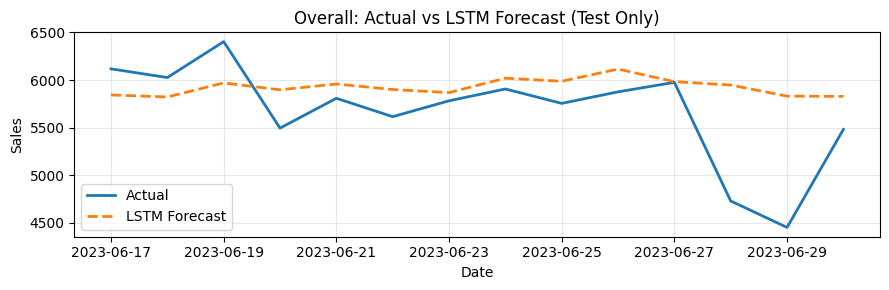

In [31]:
lstm_df = overall_daily_df.dropna().copy()

y = lstm_df['y'].astype(float)
X = lstm_df[LSTM_FEATURES].copy()

# One-hot encode day_of_week (لأنها categorical)
X = X.copy()
X['day_of_week'] = X['day_of_week'].astype(int)
dow = pd.get_dummies(X['day_of_week'], prefix="dow", drop_first=True)
X = X.drop(columns=['day_of_week'])
X = pd.concat([X, dow], axis=1).astype(float)

# Split (last TEST_DAYS)
X_train = X.iloc[:-TEST_DAYS]
X_test  = X.iloc[-TEST_DAYS:]
y_train = y.iloc[:-TEST_DAYS]
y_test  = y.iloc[-TEST_DAYS:]

# Scale
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_test_s  = x_scaler.transform(X_test)

y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_s  = y_scaler.transform(y_test.values.reshape(-1,1))

# Sequences (train)
X_tr, y_tr = make_sequences(X_train_s, y_train_s, window=WINDOW)

# Sequences (test uses last WINDOW from train + full test)
X_comb = np.vstack([X_train_s[-WINDOW:], X_test_s])
y_comb = np.vstack([y_train_s[-WINDOW:], y_test_s])
X_te, y_te = make_sequences(X_comb, y_comb, window=WINDOW)

# Model
model_overall = build_lstm(WINDOW, X_tr.shape[2])
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model_overall.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=80,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

pred_s = model_overall.predict(X_te, verbose=0)
y_pred = y_scaler.inverse_transform(pred_s).ravel()
y_true = y_scaler.inverse_transform(y_te.reshape(-1,1)).ravel()

overall_lstm_pred = pd.Series(y_pred, index=y_test.index, name="lstm_forecast")
overall_lstm_true = pd.Series(y_true, index=y_test.index, name="actual")

overall_lstm_mae = mean_absolute_error(overall_lstm_true, overall_lstm_pred)
print(f"LSTM Overall MAE (Test-{TEST_DAYS} days): {overall_lstm_mae:.2f}")

overall_lstm_pack = {
    "model": model_overall,
    "x_scaler": x_scaler,
    "y_scaler": y_scaler,
    "x_cols": list(X.columns)
}

plot_test_only_lstm(overall_lstm_true, overall_lstm_pred, title="Overall: Actual vs LSTM Forecast (Test Only)")

### 6.3) LSTM (Branch-level)

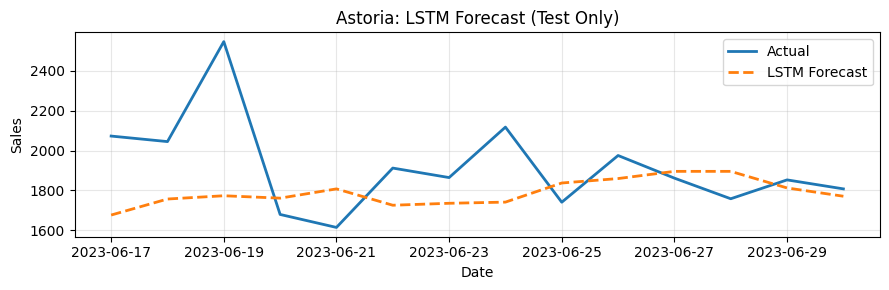

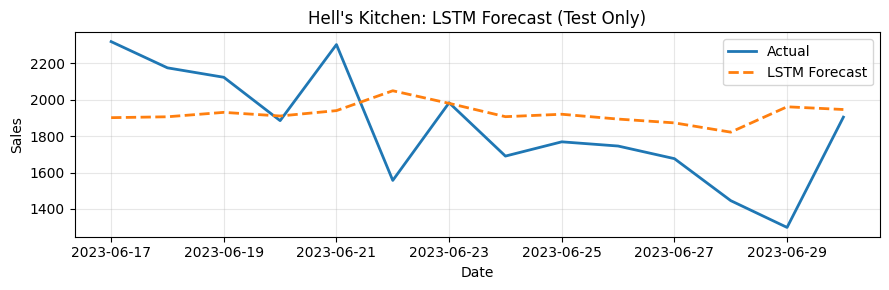

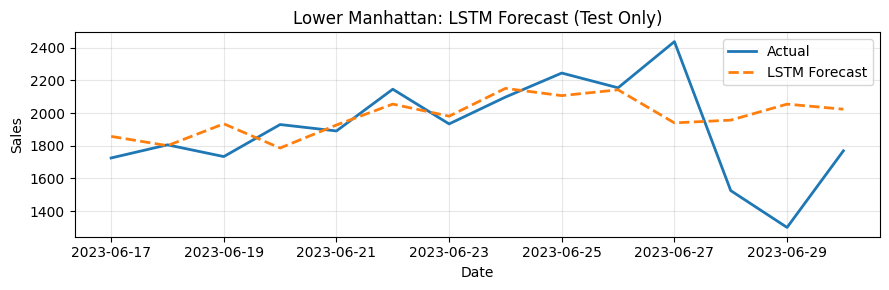

In [32]:
branches = branch_daily_wide.columns.tolist()
branch_lstm_results = {}

for b in branches:
    df_b = prepare_branch_lstm_df(b)

    y_b = df_b['y'].astype(float)
    X_b = df_b[['is_weekend','day_of_week','avg_temp','rain','cold_day','hot_day','rainy_day',
                'lag_1','lag_7','roll_mean_7','roll_std_7']].copy()

    # one-hot day_of_week
    X_b['day_of_week'] = X_b['day_of_week'].astype(int)
    dow = pd.get_dummies(X_b['day_of_week'], prefix="dow", drop_first=True)
    X_b = X_b.drop(columns=['day_of_week'])
    X_b = pd.concat([X_b, dow], axis=1).astype(float)

    # split
    X_train = X_b.iloc[:-TEST_DAYS]
    X_test  = X_b.iloc[-TEST_DAYS:]
    y_train = y_b.iloc[:-TEST_DAYS]
    y_test  = y_b.iloc[-TEST_DAYS:]

    # scale
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_s = x_scaler.fit_transform(X_train)
    X_test_s  = x_scaler.transform(X_test)
    y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_s  = y_scaler.transform(y_test.values.reshape(-1,1))

    # sequences
    X_tr, y_tr = make_sequences(X_train_s, y_train_s, window=WINDOW)
    X_comb = np.vstack([X_train_s[-WINDOW:], X_test_s])
    y_comb = np.vstack([y_train_s[-WINDOW:], y_test_s])
    X_te, y_te = make_sequences(X_comb, y_comb, window=WINDOW)

    # fit
    m = build_lstm(WINDOW, X_tr.shape[2])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    m.fit(
        X_tr, y_tr,
        validation_split=0.2,
        epochs=80,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # predict
    pred_s = m.predict(X_te, verbose=0)
    y_pred = y_scaler.inverse_transform(pred_s).ravel()
    y_true = y_scaler.inverse_transform(y_te.reshape(-1,1)).ravel()

    y_pred_s = pd.Series(y_pred, index=y_test.index, name="lstm_forecast")
    y_true_s = pd.Series(y_true, index=y_test.index, name="actual")

    mae_b = mean_absolute_error(y_true_s, y_pred_s)

    branch_lstm_results[b] = {
    "y_test": y_true_s,
    "y_pred": y_pred_s,
    "mae": mae_b,
    "model": m,
    "x_scaler": x_scaler,
    "y_scaler": y_scaler,
    "x_cols": list(X_b.columns)
    }

    r = branch_lstm_results[b]
    plot_test_only_lstm(r["y_test"], r["y_pred"], title=f"{b}: LSTM Forecast (Test Only)")

### 6.4) Summary Table (Overall + Branches)

In [33]:
# Summary table
lstm_branch_mae_df = (
    pd.DataFrame({
        "branch": list(branch_lstm_results.keys()),
        "mae": [branch_lstm_results[k]["mae"] for k in branch_lstm_results.keys()]
    })
    .sort_values("mae")
    .reset_index(drop=True)
)

lstm_branch_mae_df = pd.concat([
    pd.DataFrame({
        "branch": ["OVERALL"],
        "mae": [overall_lstm_mae]
    }),
    lstm_branch_mae_df
], ignore_index=True)

lstm_branch_mae_df

,branch,mae
0,OVERALL,383.955261
1,Lower Manhattan,199.980480
2,Astoria,206.103011
3,Hell's Kitchen,254.268737


## 7) Comparison & Save Best Models

In [34]:
# Overall winner
overall_winner = "SARIMAX" if overall_mae <= overall_lstm_mae else "LSTM"
print("Overall winner:", overall_winner)

# Branch winner table
compare_df = sarimax_branch_mae_df.rename(columns={"mae":"sarimax_mae"}).merge(
    lstm_branch_mae_df.rename(columns={"mae":"lstm_mae"}), on="branch", how="inner"
)

compare_df["winner"] = np.where(compare_df["sarimax_mae"] <= compare_df["lstm_mae"], "SARIMAX", "LSTM")
compare_df["delta_mae"] = compare_df["lstm_mae"] - compare_df["sarimax_mae"]  # + يعني SARIMAX أفضل
compare_df.sort_values(["branch"]).head(10)

Overall winner: LSTM


,branch,sarimax_mae,lstm_mae,winner,delta_mae
2,Astoria,266.775915,206.103011,LSTM,-60.672903
3,Hell's Kitchen,369.350167,254.268737,LSTM,-115.081431
1,Lower Manhattan,244.694201,199.980480,LSTM,-44.713721
0,OVERALL,437.035367,383.955261,LSTM,-53.080106


### Discussion of Results

The final evaluation demonstrates that LSTM outperformed SARIMAX in terms of MAE at both the overall and branch levels. This indicates that nonlinear temporal dependencies and internal time-series dynamics play a significant role in the data. While SARIMAX is theoretically well-suited for modeling seasonality and exogenous variables, post-model analysis )section 8) suggests that such external effects were weakly encoded in the dataset. Consequently, LSTM proved more effective in capturing complex patterns arising from aggregated and branch-specific behaviors.



In [38]:
SAVE_DIR = "best_models"
os.makedirs(SAVE_DIR, exist_ok=True)

if overall_winner == "SARIMAX":
    overall_sarimax_res.save(os.path.join(SAVE_DIR, "OVERALL_SARIMAX.pkl"))
else:
    overall_lstm_pack["model"].save(os.path.join(SAVE_DIR, "OVERALL_LSTM.keras"))
    joblib.dump(overall_lstm_pack["x_scaler"], os.path.join(SAVE_DIR, "OVERALL_LSTM_x_scaler.pkl"))
    joblib.dump(overall_lstm_pack["y_scaler"], os.path.join(SAVE_DIR, "OVERALL_LSTM_y_scaler.pkl"))
    joblib.dump(overall_lstm_pack["x_cols"],   os.path.join(SAVE_DIR, "OVERALL_LSTM_x_cols.pkl"))

In [39]:
branches_only = compare_df[compare_df["branch"] != "OVERALL"].copy()

for _, row in branches_only.iterrows():
    b = row["branch"]
    w = row["winner"]

    if w == "SARIMAX":
        sarimax_branch_results[b]["fitted"].save(os.path.join(SAVE_DIR, f"{b}_SARIMAX.pkl"))
    else:
        pack = branch_lstm_results[b]
        pack["model"].save(os.path.join(SAVE_DIR, f"{b}_LSTM.keras"))
        joblib.dump(pack["x_scaler"], os.path.join(SAVE_DIR, f"{b}_LSTM_x_scaler.pkl"))
        joblib.dump(pack["y_scaler"], os.path.join(SAVE_DIR, f"{b}_LSTM_y_scaler.pkl"))
        joblib.dump(pack["x_cols"],   os.path.join(SAVE_DIR, f"{b}_LSTM_x_cols.pkl"))

print("✅ Saved best models without refit in:", SAVE_DIR)

✅ Saved best models without refit in: best_models


## 8) Post-Model Data Diagnostics

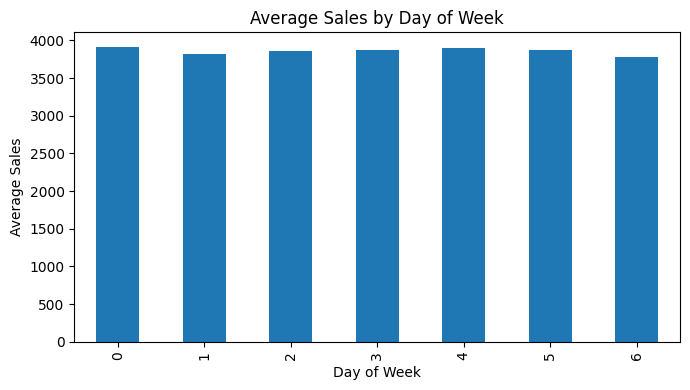

In [40]:
dow_sales = (
    overall_daily_df
    .groupby("day_of_week")["y"]
    .mean()
)

plt.figure(figsize=(7,4))
dow_sales.plot(kind="bar")
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

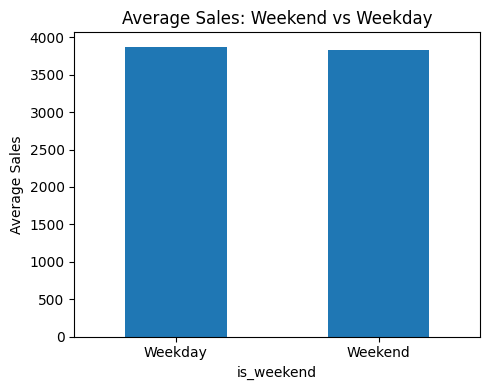

In [41]:
weekend_sales = overall_daily_df.groupby("is_weekend")["y"].mean()

plt.figure(figsize=(5,4))
weekend_sales.plot(kind="bar")
plt.title("Average Sales: Weekend vs Weekday")
plt.xticks([0,1], ["Weekday", "Weekend"], rotation=0)
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

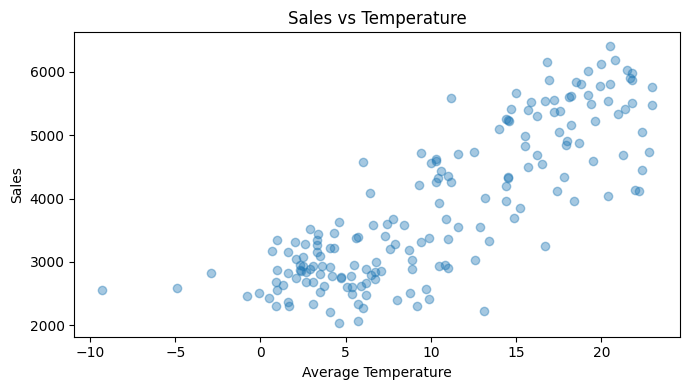

In [42]:
plt.figure(figsize=(7,4))
plt.scatter(overall_daily_df["avg_temp"], overall_daily_df["y"], alpha=0.4)
plt.xlabel("Average Temperature")
plt.ylabel("Sales")
plt.title("Sales vs Temperature")
plt.tight_layout()
plt.show()

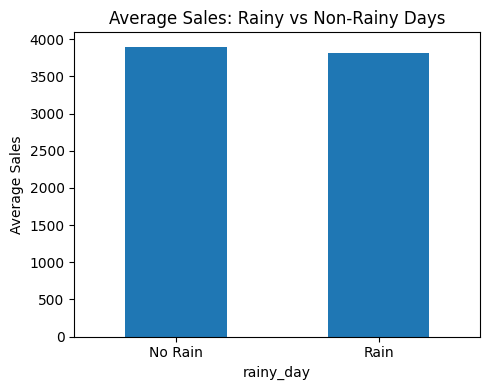

In [43]:
rain_sales = overall_daily_df.groupby("rainy_day")["y"].mean()

plt.figure(figsize=(5,4))
rain_sales.plot(kind="bar")
plt.title("Average Sales: Rainy vs Non-Rainy Days")
plt.xticks([0,1], ["No Rain", "Rain"], rotation=0)
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

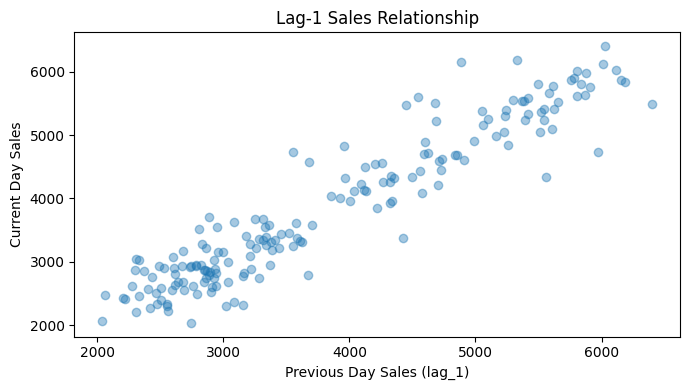

In [44]:
plt.figure(figsize=(7,4))
plt.scatter(overall_daily_df["lag_1"], overall_daily_df["y"], alpha=0.4)
plt.xlabel("Previous Day Sales (lag_1)")
plt.ylabel("Current Day Sales")
plt.title("Lag-1 Sales Relationship")
plt.tight_layout()
plt.show()

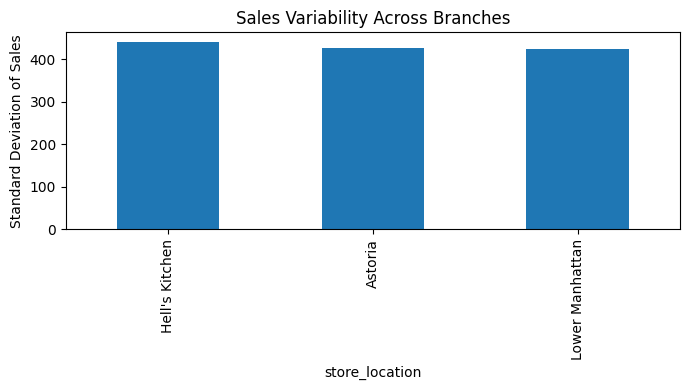

In [45]:
branch_std = branch_daily_wide.std().sort_values(ascending=False)

plt.figure(figsize=(7,4))
branch_std.plot(kind="bar")
plt.title("Sales Variability Across Branches")
plt.ylabel("Standard Deviation of Sales")
plt.tight_layout()
plt.show()

Post-model exploratory analysis indicates that external variables such as weather conditions and weekend indicators exhibit minimal variation across sales levels. This suggests that these factors were not strongly encoded in the data generation process. As a result, improvements achieved by LSTM are primarily attributed to its ability to model internal temporal dependencies rather than exogenous effects.


## 9) Conclusion

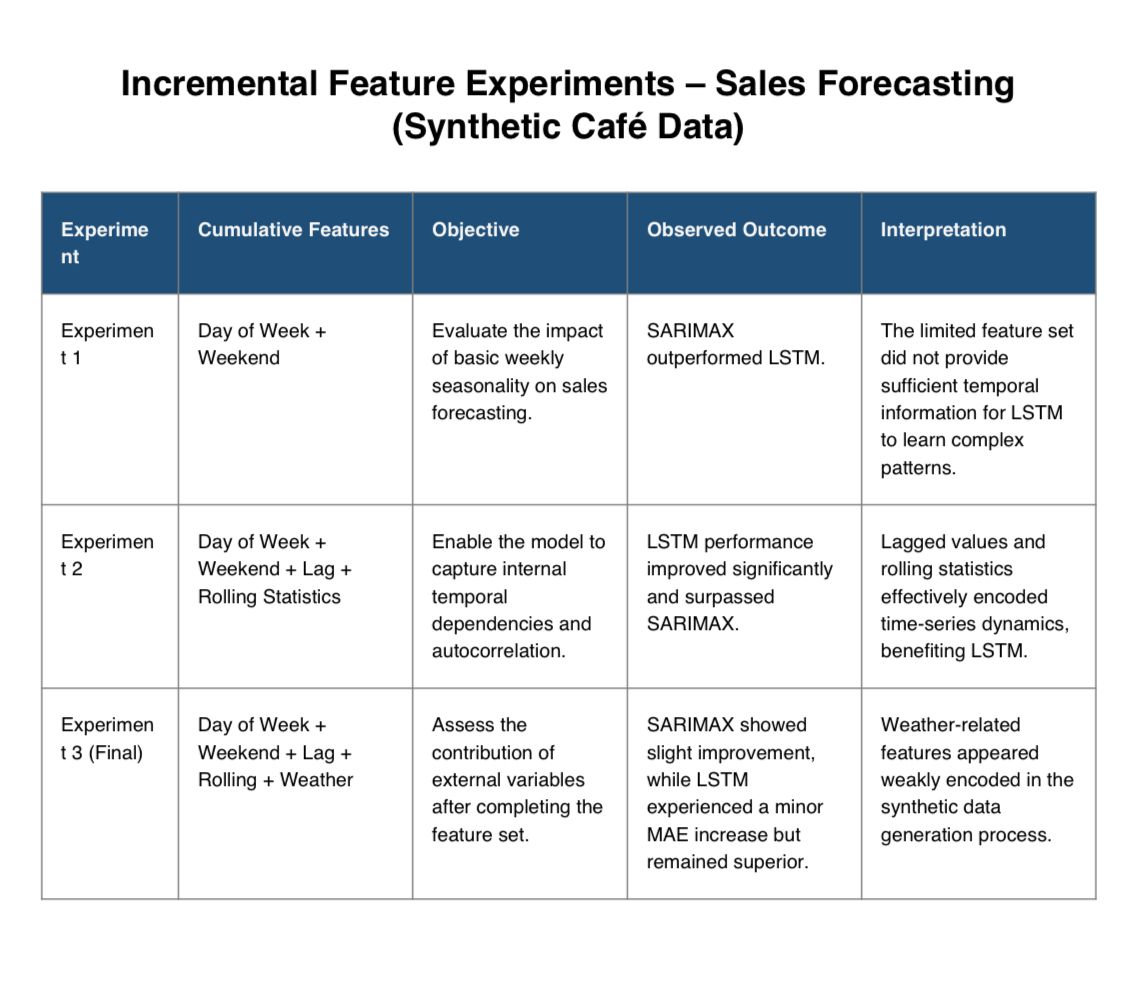